# Best Models

Define models:

In [1]:
source("helpers.r")
library(magrittr)
library(glmnet)
library(rpart)
library(ipred)
library(randomForest)
library(fastAdaboost)
library(gbm)
library(xgboost)

learner_A <- function(training, test) {
  name <- "lg full"
  
  fit <- glm(target ~ ., data=training, family =binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
  
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))
}


learner_B <- function(training, test) {
  name <- "lg forwad selection"
  
  fit <- glm(target ~ thal + ca + cp + slope + oldpeak + sex + trestbps, data=training, family =binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
  
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))
}

learner_C <- function(training, test) {   
  name <- "glm 5 variables LASSO"
    
  fit <- glm(target ~ thalach + oldpeak + ca + cp + thal, data=training, family = binomial(link = "logit"))
  y_probabilities <- predict(fit, test,  type="response")
  y_true <- ifelse(test$target == "no_disease", 0, 1)
    
  auc <- AUC(y_true = y_true, y_pred = y_probabilities)
  return(list(name = name, auc = auc))

}


learner_D <- function(training, test) {   
    name <- "glmnet"
    
    model <- model.matrix(target ~ ., training)[,-1]
    y <- ifelse(training$target == "no_disease", 0, 1)
    fit <- glmnet(model, y, alpha = 0, family = "binomial", lambda = 0.5, standardize = TRUE)

    x_test  <- model.matrix(target ~ ., test)[,-1]
    y_probabilities <- predict(fit, x_test,  type="response")
    y_true <- ifelse(test$target == "no_disease", 0, 1)

    auc <- AUC(y_true = y_true, y_pred = y_probabilities)
    return(list(name = name, auc = auc))
}

learner_E  <- function(training, test){
    
        name <- "rpart"
    
    model <- model.matrix(target ~ ., training)[,-1]
    y <- ifelse(training$target == "no_disease", 0, 1)
   
        
    fit <- rpart(target ~., data=df, method = "class",
                 control = rpart.control(maxdepth = 5, minbucket = 10, minsplit = 10), cp = 0.1)

    y_probabilities <- predict(fit, test)[,2]
    y_true <- ifelse(test$target == "no_disease", 0, 1)

    auc <- AUC(y_true = y_true, y_pred = y_probabilities)
    return(list(name = name, auc = auc))

}

learner_F <- function(training, test){
    
        name <- "bagging"
    
    model <- model.matrix(target ~ ., training)[,-1]
    y <- ifelse(training$target == "no_disease", 0, 1)
   
        
  fit <- bagging(target ~ ., training,
                 nbagg = 100,
                 coob = FALSE,
                 control = rpart.control(maxdepth = 20, minbucket = 7,
                                         minsplit = 10), cp = 0.1)
  
  y_probabilities <- predict(fit, test, type = "prob")[,2]
    y_true <- ifelse(test$target == "no_disease", 0, 1)

    auc <- AUC(y_true = y_true, y_pred = y_probabilities)
    return(list(name = name, auc = auc))

}


learner_G <- function(training, test){
    
        name <- "randomforest"
    
    model <- model.matrix(target ~ ., training)[,-1]
    y <- ifelse(training$target == "no_disease", 0, 1)
   
        
     fit <- randomForest(target ~ ., training,  ntree = 100, mtry = 2,
                        nodesize = 10, maxnodes = 4)
    # using ratio of poisitive labels as probability
    y_probabilities <- predict(fit, test, type = "vote")[,2]
    
    y_true <- ifelse(test$target == "no_disease", 0, 1)

    auc <- AUC(y_true = y_true, y_pred = y_probabilities)
    return(list(name = name, auc = auc))

}

learner_H <- function(training, test){
    
        name <- "adaboost"
    
    model <- model.matrix(target ~ ., training)[,-1]
    y <- ifelse(training$target == "no_disease", 0, 1)
   
    training <- as.data.frame(training) 
   fit <- adaboost(target ~ ., training, nIter = 100)
    y_probabilities <- predict(fit, test)$prob[,2]
    
    y_true <- ifelse(test$target == "no_disease", 0, 1)

    auc <- AUC(y_true = y_true, y_pred = y_probabilities)
    return(list(name = name, auc = auc))

}

learner_I <- function(training, test){
    
    name <- "gbm"

    y <- ifelse(training$target == "no_disease", 0, 1)

    training$target <- ifelse(training$target == "no_disease", 0, 1)

    fit <- gbm(target ~ ., data = training, distribution = "bernoulli",
         n.trees = 10, interaction.depth = 10,
         n.minobsinnode = 5)



    y_probabilities <- predict(fit, test, type = "response", n.trees = 10)
   
    
    y_true <- ifelse(test$target == "no_disease", 0, 1)

    auc <- AUC(y_true = y_true, y_pred = y_probabilities)
    return(list(name = name, auc = auc))

}







learner_J <- function(training, test) {
    name <- "xgboost"

    df_matrix <- sparse.model.matrix(target ~ .-1, data = training)
    dtrain <- xgb.DMatrix(df_matrix, label = ifelse(training$target == "no_disease", 0, 1))

    param <- list(max_depth = 2, eta = 0.1, verbose = 0, nthread = 2,
          objective = "binary:logistic")

    fit <- xgb.train(param, dtrain, nrounds = 50)

    df_matrix <- sparse.model.matrix(target ~ .-1, data = test)
    dtest <- xgb.DMatrix(df_matrix, label = ifelse(test$target == "no_disease", 0, 1))
    
    y_probabilities <- predict(fit, dtest)
    y_true <- ifelse(test$target == "no_disease", 0, 1)

    auc <- AUC(y_true = y_true, y_pred = y_probabilities)
    return(list(name = name, auc = auc))
}





Warning message:
"package 'tidyverse' was built under R version 3.6.1"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Warning message:
"package 'MLmetrics' was built under R version 3.6.1"
Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is 

Compare the models:

model,MeanAUC
lg forwad selection,0.9227572
glmnet,0.9196304
randomforest,0.9129620
bagging,0.9100699
glm 5 variables LASSO,0.9054346
lg full,0.9035265
gbm,0.9029670
rpart,0.8997053
xgboost,0.8990210
adaboost,0.8705095


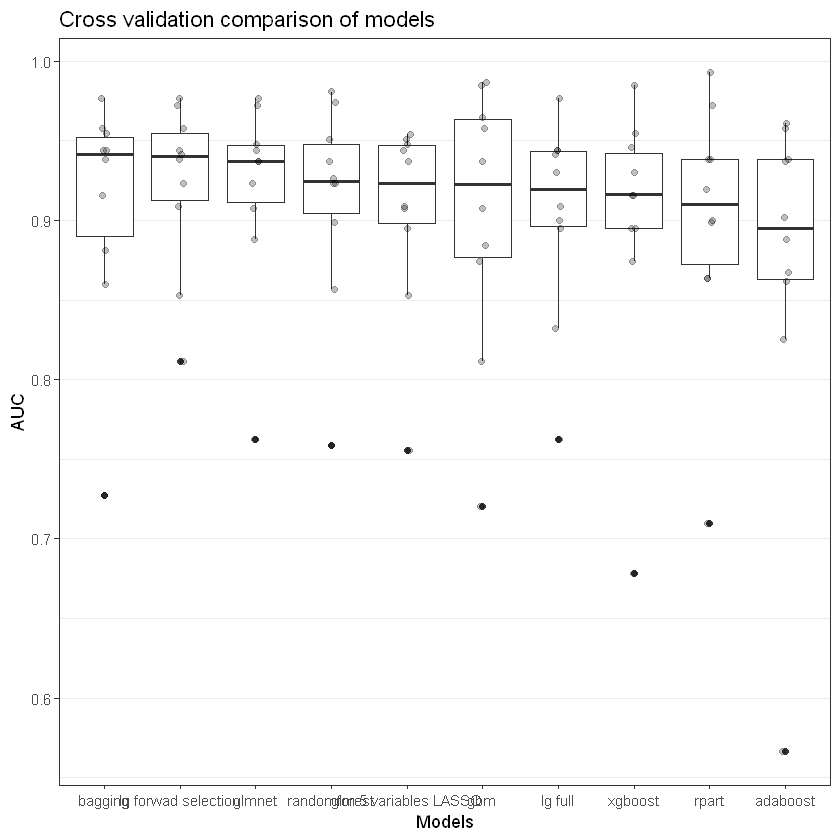

In [2]:
df <- get_training_df_clean()

learners <- list(learner_A, learner_B, learner_C, learner_D, learner_E, learner_F, learner_G, learner_H, learner_I, learner_J)

result <- cv_compare_learner(learners, df)

plot_best_learners(result)

result %>% 
  group_by(model) %>%
  summarise(MeanAUC = mean(auc)) %>%
  arrange(desc(MeanAUC))